<center>
    <img style="float: left;" src="Mix_colour.png" width="200"></img>
</center>

<br/><br/>
<br/><br/>

# Feature Selection

In the reading material we discussed a few methods for feature selection that one can use to simplify the model without losing too much accuracy. In this notebook we will consider the following problem: if we have many features in a model, how do we know which features are the most important, and which ones we can drop.

For simplicity, we are not considering a test/train split or cross validation in this notebook. However those concepts still apply, and in a real-world setting they should be used alongside feature selection.

## Data

We will use a toy dataset to test the feature selection. We will start by loading the [Boston house market](https://scikit-learn.org/stable/datasets/index.html#boston-house-prices-dataset) dataset that we already used in the previous assignment. It contains 506 records with 12 features from which one can predict house prices. We will consider a simple linear model, and estimate its validity using $k$-fold cross validation. The idea in feature selection is to repeat the cross validation using different set of features.

After loading the dataset, we will first have all features in `x0` and the target vector (i.e. the house prices) in `y`. 

The first thing we do is to standardise `x0` obtaining a new variable `x` (recall that to standardise means to subtract the mean and scale to have unit variance).

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

df_boston = pd.read_csv('/home/jovyan/Data/boston.csv')

np.random.seed(42)  # setting the random seed makes the example reproducible

x0 = df_boston.iloc[:,:-1] # select all feature columns
y = df_boston['PRICE'] # select target column

scaler = preprocessing.StandardScaler().fit(x0)
x = scaler.transform(x0)

## Forward search

Recall from the corresponding section, that the `mlxtend` package provides a [SequentialFeatureSelector](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#api) class that offers both forward and backward search. Have a quick look at its documentation.

### Q1:

Implement forward feature selection for the linear regression model.

**Hint:**
* Start by defining an instance of the `LinearRegression` class. 
* Define an instance of `SequentialFeatureSelector` and store it in the `sfs` variable (use `sfs = SequentialFeatureSelector()`). When calling `SequentialFeatureSelector()`, you'll need to pass the `LinearRegression` instance, the maximum amount of features that we want to explore (`k_features=12`), flag for the forward search (`forward=True`), $R^2$ scoring (`scoring='r2'`), and 5-fold cross validation (`cv=5`).
* Finally, have the feature selector fit the data and search for features, by calling its `.fit(x,y)` method.

We will provide two instructions to get a list of all scores, and find the number of features for which the score is maximised.

In [2]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# (approx. 3 lines of code)
### START ANSWER HERE ###
linear_regression = LinearRegression()
sfs = SequentialFeatureSelector(linear_regression, k_features=12, forward=True, scoring='r2', cv=5)
sfs.fit(x, y)
### END ANSWER HERE ###

# the next lines calculate the scores from the sfs instance
scores_forward = [ sfs.subsets_[i]['avg_score']  for i in sfs.subsets_.keys() ]
max_features_forward = 1+np.argmax(scores_forward)
max_score_forward = np.max(scores_forward)

print('Number of features the score is maximised = %i \nMaximum score = %f' %(max_features_forward,max_score_forward))

Number of features the score is maximised = 9 
Maximum score = 0.460051


**Expected Output**: 
<table style="width:100%">
    <tr> 
        <td> Number of features the score is maximised</td> 
        <td> 9
        </td> 
    </tr>
    <tr> 
        <td> Maximum score</td> 
        <td> 0.460051 </td> 
    </tr>
</table> 

In [3]:
# nbgrader cell


Let's now look at the results of our feature search. The `sfs` object contains a `.subsets_` property that holds a [dictionary](https://www.w3schools.com/python/python_dictionaries.asp); the dictionary keys are the number of features. Let's build an array of the average scores and plot it.

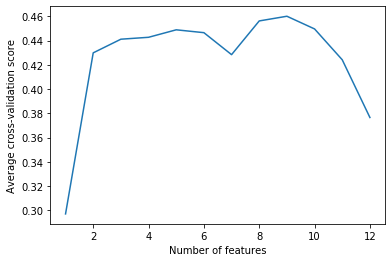

In [4]:
num_features = [subset for subset in sfs.subsets_]
scores = [ sfs.subsets_[i]['avg_score']  for i in sfs.subsets_.keys() ]

plt.plot(num_features, scores)
plt.xlabel('Number of features')
plt.ylabel('Average cross-validation score')
plt.show()

The maximum score is found when using 9 features. It's interesting to note that 2 features is the bare minimum to have a decent fit, so we learn that there's enough structure in this problem that it cannot be caught by one single feature. We also see that there is a sharp drop in the score when using 10 features or more; from this we learn that overfitting can be a serious issue in these data. Finally, we can notice that the score increase from 2 to 9 features is not flat and there is a drop when using 7 features.

### Q2:
For the record, what are three most important features? Let's extract them. 

**Hints:**
* First, take the indices of the three most important features: they can be obtained from `sfs.subsets_[3]['feature_idx']`, store them in a variable called `threefeatures`. 
* Then, the list `df_boston.columns` will contain the feature names (note that the last column `PRICE` is the target of the linear regression). The indices of the elements that you need are in `threefeatures[0]`, `threefeatures[1]` and `threefeatures[2]`. So, extract the elements that you need from the list of the column names and store them in three variables called `feature1`, `feature2` and `feature3`. 

Finally we'll print the three names.

In [5]:
# (approx. 4 lines of code)
### START ANSWER HERE ###
threefeatures = sfs.subsets_[3]['feature_idx']
feature1 = df_boston.columns[threefeatures[0]]
feature2 = df_boston.columns[threefeatures[1]]
feature3 = df_boston.columns[threefeatures[2]]
### END ANSWER HERE ###

print('Indices of the features: ', threefeatures)
print('Three most important features: ', feature1, feature2, feature3)

Indices of the features:  (3, 10, 11)
Three most important features:  CHAS PTRATIO LSTAT


**Expected Output**: 
<table style="width:100%">
    <tr> 
        <td> Indices of the features</td> 
        <td> (3, 10, 11)
        </td> 
    </tr>
    <tr> 
        <td> Three most important features</td> 
        <td> CHAS PTRATIO LSTAT </td> 
    </tr>
</table> 

In [ ]:
# nbgrader cell


## Backward search

The `SequentialFeatureSelector` in `mlxtend` also offers an option for backward search. Let's try it first, and then we'll see another option.

### Q3:

Look again at the code for Q1 and at the above plot. Now do the same for the backward search, all steps from instantiating a `SequentialFeatureSelector` to obtaining the number of features that maximises the score, and to finally showing the plot. It's quite easy, just remember to set `forward=False` and choose `k_features=1` so you try all possibilities from 12 down to 1 feature. Put the maximum score and the number of features in the `max_score_backward` and `max_features_backward` variables, respectively.

In [7]:
# (approx. 10 lines of code)
### START ANSWER HERE ###
sfs = SequentialFeatureSelector(linear_regression, k_features=1, forward=False, scoring='r2', cv=5)
sfs.fit(x, y)

scores_backward = [sfs.subsets_[i]['avg_score'] for i in sfs.subsets_.keys()]
max_features_backward = len(sfs.subsets_.keys()) - np.argmax(scores_backward)
max_score_backward = np.max(scores_backward)
### END ANSWER HERE ###

print('Number of features the score is maximised = %i \n Maximum score = %f' %(max_features_backward,max_score_backward))

Number of features the score is maximised = 10 
 Maximum score = 0.487433


**Expected Output**: 
<table style="width:100%">
    <tr> 
        <td> Number of features the score is maximised</td> 
        <td> 10
        </td> 
    </tr>
    <tr> 
        <td> Maximum score</td> 
        <td> 0.487433 </td> 
    </tr>
</table> 

In [8]:
# nbgrader cell


Compare the max score in both cases. The backward search identified better models than the forward selection! What happened?

What happened is that the forward and backward search algorithms are not exploring all possible combinations of features (there are $2^{12}=4096$ possible combinations of features in this problem!) but just two subsets (one for forward, one for backward), each one of them containing 12 nested sets of features. This brings us to the next question...

### Q4:

What are the three most important features identified by backward search? Approach it analogous to Q2, and store the indices in `threefeatures` and the names in `feature1`, `feature2` and `feature3`.



In [9]:
# (approx. 4 lines of code)
### START ANSWER HERE ###
threefeatures = sfs.subsets_[3]['feature_idx']
feature1 = df_boston.columns[threefeatures[0]]
feature2 = df_boston.columns[threefeatures[1]]
feature3 = df_boston.columns[threefeatures[2]]
### END ANSWER HERE ###

print('Indices of the features: ', threefeatures)
print('Three most important features: ', feature1, feature2, feature3)

Indices of the features:  (7, 10, 11)
Three most important features:  DIS PTRATIO LSTAT


**Expected Output**: 
<table style="width:100%">
    <tr> 
        <td> Indices of the features</td> 
        <td> (7, 10, 11)
        </td> 
    </tr>
    <tr> 
        <td> Three most important features</td> 
        <td> DIS PTRATIO LSTAT </td> 
    </tr>
</table> 

In [ ]:
# nbgrader cell


Even when selecting just three features, forward and backward search found two different sets! Somewhat reassuringly, the two subsets partly overlap, and only one feature is different between them.

What happens if we redo the search using a different Python package? We can try and use [Recursive feature elimination with cross validation (RFECV)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) that also offers backward search.

### Q5:

Use the backward search in `RFECV` to estimate again the cross validation score and the three most important features. Use the `cv=5` parameter when instantiating an `RFECV` object to specify that we want 5-fold cross validation, and `scoring='r2'` to use $R^2$ as score.

`RFECV` has a `.grid_scores_` property that contains the scores array, ordered for increasing number of features. Use `.grid_scores_` to find the maximum score and the relative number of features; put them in `max_score_rfecv` and `max_features_rfecv`. 

Finally, plot the scores (**Hint**: use `range(1,len(rfecv.grid_scores_)+1)` as your abscissa vector).



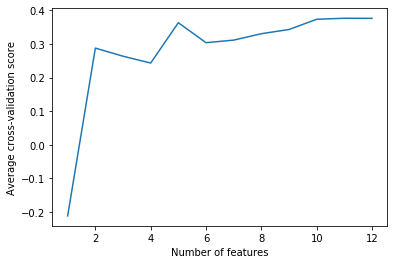

Number of features the score is maximised = 11 
 Maximum score = 0.376872


In [13]:
from sklearn.feature_selection import RFECV

# (approx. 8 lines of code)
### START ANSWER HERE ###
rfecv = RFECV(estimator=linear_regression, cv=5, scoring='r2')
rfecv.fit(x, y)

max_score_rfecv = np.max(rfecv.grid_scores_)
max_features_rfecv = 1 + np.argmax(rfecv.grid_scores_)

plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.xlabel('Number of features')
plt.ylabel('Average cross-validation score')
plt.show()
### END ANSWER HERE ###


print('Number of features the score is maximised = %i \n Maximum score = %f' %(max_features_rfecv, max_score_rfecv))

**Expected Output**: 
<table style="width:100%">
    <tr> 
        <td> Number of features the score is maximised</td> 
        <td> 11
        </td> 
    </tr>
    <tr> 
        <td> Maximum score</td> 
        <td> 0.376872 </td> 
    </tr>
</table> 

In [ ]:
# nbgrader cell


Quite interestingly, the results from backward search done by `RFECV` are different to those from `SequentialFeatureSelector`, with `RFECV` finding a maximum for 11 features. By looking at the plot, two or three features could already provide an acceptable fit to the data, consistently with what we have seen before. However, with `RFECV` it is difficult to get the "three most important features" as we have seen before, because it only provides an interface to the maximum-score fit (i.e., that with 11 features).

Another difference between `mlxtend` and `RFECV` is that the latter gives different results depending on if the $x$ has been standardised (exercise: remove the feature scaling in the first cell of this notebook, and see how the results change - but do this on a duplicate of this notebook, otherwise all grading cells might be messed up!).

## Regularisation

The last part of this notebook concerns regularisation with the $L_1$ and $L_2$ penalties, that in the context of regression are also known as lasso regression and ridge regression, respectively. Both of them impose a penalty on large weights; therefore the weights for not-so-important variables are kept low. The main practical difference is that in $L_1$ regularisation, the weights will drop faster towards 0, so that it is possible that it excludes variables from the model more efficiently.

It's important that regularisation is performed on standardised features, because otherwise the regression coefficients could be more sensitive to the feature scales than to their importance.


### Q6:

Lasso is provided by `sklearn.linear_model`. Have a look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), import and instantiate a Lasso regressor with parameter `alpha=0.5`, putting it in the variable `lasso`. Finally call the `.fit(x,y)` method on it to fit our data.

In [14]:
# (approx. 3 lines of code)
### START ANSWER HERE ###
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.5)
lasso.fit(x, y)
### END ANSWER HERE ###

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [15]:
# nbgrader cell


What features have been selected by the lasso?  The `.coef_` property contains the fit coefficients. Let's take a look:

In [16]:
print('Coefficients: \n', lasso.coef_)  
print('Indices of non-zero elements: ', np.where(lasso.coef_))   

Coefficients: 
 [-2.16484072e-01  0.00000000e+00 -0.00000000e+00  4.16671801e-01
 -2.34950025e-03  2.90994049e+00 -0.00000000e+00 -1.51556267e-01
 -0.00000000e+00 -9.52790533e-02 -1.58756785e+00 -3.79868515e+00]
Indices of non-zero elements:  (array([ 0,  3,  4,  5,  7,  9, 10, 11]),)


So 8 features have been selected; this number depends on the $\alpha$ parameter that we set.

### Q7:

How many features are selected when using different $\alpha$?  

Let's use a loop that goes from `alpha=0.1` to `alpha=10` with a step of 0.1, to get the number of features that have been selected. 
We will start the loop, and you need to write the inner part of it: 
* instantiate a Lasso regressor and __name the instance `lasso`__
* fit it to x,y
* get the number of selected features from `len(np.where(lasso.coef_)[0])`
* call `num_features.append()` to add the number of selected features to the `num_features` list).

Finally, outside the loop, we make a plot of `alphas` vs. number of selected features (`num_features`).

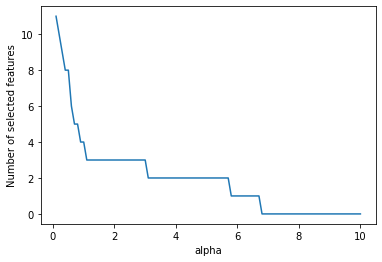

In [17]:
alphas = np.arange(.1,10.1,.1)
num_features = [] # store the number of selected features here

for a in alphas:
# (approx. 3 lines of code)
### START ANSWER HERE ###
    lasso = Lasso(alpha=a)
    lasso.fit(x, y)
    num_features_a = len(np.where(lasso.coef_)[0])
    num_features.append(num_features_a)
### END ANSWER HERE ###

plt.plot(alphas, num_features)
plt.xlabel('alpha')
plt.ylabel('Number of selected features')
plt.show()

In [ ]:
# nbgrader cell


So the larger the $\alpha$, the less features get selected. This happens because after certain thresholds, the coefficient for a given variable reduces to zero. But, what happens to the coefficients when we choose an $\alpha$ that's between the thresholds?

The _regularisation path_ plot can be used to understand how the coefficients evolve. An example is [here](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#lasso-and-elastic-net); the `lasso_path` method can be used to obtain the coefficients for a grid of $\alpha$. Also, it is conventional to plot it as a function of $-\log(\alpha)$, so we will stick to the convention. Just remember that the $x$ axis is reversed with respect to the previous plot.

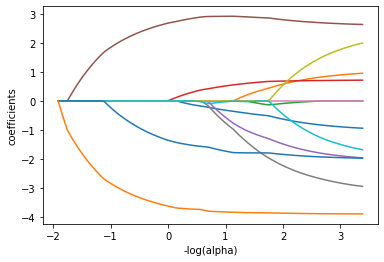

In [18]:
from sklearn.linear_model import lasso_path
alphas_lasso, coefs_lasso, _ = lasso_path(x, y, 5e-3)
for cl in coefs_lasso:
    plt.plot(-np.log(alphas_lasso), cl)
plt.xlabel('-log(alpha)')
plt.ylabel('coefficients')
plt.show()

### Q8 (multiple choice):

Look at the above plots and which of the following statement are true:
1. More features get selected when the regularisation strength (alpha) is increased
2. Less features get selected when the regularisation strength (alpha) is increased
3. The regularisation path can be used to find the three most important features, by choosing an appropriate alpha
4. Regularisation is so powerful that we don't need cross validation

In [21]:
# Fill in all the numbers corresponding to your answer inside the brackets: Q8_answer = [5,6]
 
### START ANSWER HERE ###
Q8_answer = [2,3]
### END ANSWER HERE ###

In [22]:
import hashlib
_myhash = lambda x: hashlib.md5(str(x).encode()).hexdigest()
if _myhash(set(Q8_answer))=='5ad06bc3b78920bcf496ed9a814cf4db':
    print('Correct!')
else:
    print('Not correct! Please try again!')

Correct!


In [ ]:
# nbgrader cell


We will now consider $L_2$ regularisation, also known as ridge regression, and draw a regularisation path for it.

From a coding point of view, ridge regression works exactly like lasso regression; we just need to import and use `Ridge` instead of `Lasso`. We need to cycle on a much larger range of strengths, like $1\le \alpha\le 10^5$, the line `alphas = np.logspace(0,5,num=100)` takes care of this.
We proceed as in Q8, the only difference is that we need to append `ridge.coef_` to `coefs`. Finally we plot `coefs` as a function of $-log(\alpha)$ (technically, `coefs` is a list of numpy arrays; the call to `plt.plot()` looks simple, but inside it will cycle over all numpy arrays and plot each of them in a different colour).

Look at the plot: no feature will be completely dropped, but some some of them will have their coefficients strongly reduced at different values of $\alpha$.

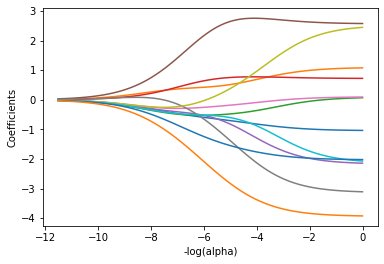

In [23]:
from sklearn.linear_model import Ridge

alphas = np.logspace(0,5,num=100)
coefs = [] #  store your scores here

for a in alphas:

    ridge = Ridge( alpha=a )
    ridge.fit(x,y)
    coefs.append(ridge.coef_)
    
plt.plot(-np.log(alphas), coefs)
plt.xlabel('-log(alpha)')
plt.ylabel('Coefficients')
plt.show()

# Good job!